In [1]:
%load_ext autoreload
%autoreload 2

from controllers import plan_trajectory
import gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
gym.logger.set_level(gym.logger.ERROR)
env = gym.make('CarRacing-v1', seed=42).env
state = env.reset()
states, actions, observations = [], [], []
done = False

In [3]:
trajectory = plan_trajectory(env)
len(trajectory), trajectory

[planning.py] planning trajectory


(1000,
 array([[ 2.16983785e+02, -5.13294577e+01,  1.41532152e+00,
          8.26507590e+00,  5.27311971e+01,  0.00000000e+00],
        [ 2.17149087e+02, -5.02748338e+01,  1.41532152e+00,
          8.26507590e+00,  5.27311971e+01,  0.00000000e+00],
        [ 2.17314388e+02, -4.92202099e+01,  1.41532152e+00,
          8.26507590e+00,  5.27311971e+01,  0.00000000e+00],
        ...,
        [ 2.15991976e+02, -5.76572014e+01,  1.41532152e+00,
          1.65301518e+01,  1.05462394e+02, -8.88178420e-14],
        [ 2.16322579e+02, -5.55479535e+01,  1.41532152e+00,
          1.65301518e+01,  1.05462394e+02, -7.77156117e-14],
        [ 2.16653182e+02, -5.34387056e+01,  1.41532152e+00,
          1.65301518e+01,  1.05462394e+02, -7.77156117e-14]]))

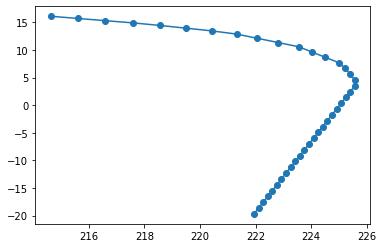

In [4]:
track = trajectory[30:70, :3]
plt.plot(track[:, 0], track[:, 1], '-o')
plt.show()

In [5]:
# from casadi import *

# # track = trajectory[:, :3]
# z_ref = MX(track.T)
# N = z_ref.shape[1]

# Q = MX(np.diag([1, 1, 1]))
# R = MX(np.eye(2)) / 100000

# dt = 0.02
# l = 1

In [6]:
# opti = casadi.Opti();

# z = opti.variable(4, N);
# opti.set_initial(z[:3, :], track.T)

# u = opti.variable(2, N-1);
# u_init = np.tile([[0], [.5]], (1, N-1))
# opti.set_initial(u, u_init)

# cost = sum([(z[:3, i] - z_ref[:, i]).T @ Q @ (z[:3, i] - z_ref[:, i]) + u[:, i].T @ R @ u[:, i] for i in range(N-1)]) \
#         + (z[:3, N-1] - z_ref[:, N-1]).T @ Q @ (z[:3, N-1] - z_ref[:, N-1])

# opti.minimize(cost);
# # opti.subject_to(-1 <= u[0, :] <= 1);
# # opti.subject_to(-1 <= z[2, :] <= 1);
# # opti.subject_to(-3 <= u[1, :] <= 3);
# # opti.subject_to(0 <= u[2, :] <= 1);

# opti.subject_to([(z[0, i+1] - z[0, i]) / dt == u[0, i] * np.cos(z[2, i]) for i in range(N-1)]);
# opti.subject_to([(z[1, i+1] - z[1, i]) / dt == u[0, i] * np.sin(z[2, i]) for i in range(N-1)]);
# opti.subject_to([(z[2, i+1] - z[2, i]) / dt == u[0, i] / l * np.tan(z[3, i]) for i in range(N-1)]);
# opti.subject_to([(z[3, i+1] - z[3, i]) / dt == u[1, i] for i in range(N-1)]);
# opti.subject_to(u[:, 0] == 0)
# opti.subject_to(z[:3, 0] == z_ref[:, 0])

# opti.solver('ipopt');

# sol = opti.solve();

In [7]:
# z_opt = sol.value(z)
# u_opt = sol.value(u)

# plt.plot(track[:, 0], track[:, 1], '-o')
# plt.plot(z_opt[0, :], z_opt[1, :], '-+')
# plt.show()

In [8]:
# print(u_opt)

In [9]:
# u_T = u_opt.T
# racecar_action = np.zeros((N-1, 3))  # third coumn is brake. It is null because 
# # it is not in the bicycle model used in the optimization solve
# racecar_action[:, 0] = z_opt.T[:-1, 3]  # steering
# racecar_action[:, 1] = u_T[:, 0]  # throttle

# racecar_action

In [10]:
# for action in racecar_action:
#     try:
#         # render environment 
#         env.render()

#         observation = env.step(action)
#     except KeyboardInterrupt:
#         done = True

In [11]:
def f(z, u, model):
    tensor = vertcat(z, u)
    layers = model.get_weights()
    L = len(layers)

    for i in range(0, L, 2):
        weight, bias = MX(layers[i].T), MX(layers[i+1])

        if i < L-2:
            tensor = tanh(weight @ tensor + bias)
        else:
            tensor = weight @ tensor + bias

    return tensor

In [12]:
from learning import load_model

Using TensorFlow backend.


In [13]:
model = load_model("../models/dynamics64.h5")

[learning.py] loading model (../models/dynamics64.h5)
__________________________________________________________________________________________________
Model: "dynamics"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z (InputLayer)                  (None, 6)            0                                            
__________________________________________________________________________________________________
u (InputLayer)                  (None, 3)            0                                            
__________________________________________________________________________________________________
input_layer (Concatenate)       (None, 9)            0           z[0][0]                          
                                                                 u[0][0]                          
_____________________________________

In [14]:
from casadi import *

z_ref = MX(track.T)
N = z_ref.shape[1]

Q = MX(np.diag([1, 1, 1]))
R = MX(np.eye(3)) / 100000

# dt = 0.02
dt = 0.02

In [15]:
opti = casadi.Opti();

u = opti.variable(3, N-1);
u_init = np.tile([[0], [.5], [0]], (1, N-1))
opti.set_initial(u, u_init)

z_0 = np.zeros((6, 1))
z_0[:3, 0] = track.T[:, 0]
z = MX(z_0)
cost = 0

for i in range(N-1):
    cost += (z[:3] - z_ref[:, i]).T @ Q @ (z[:3] - z_ref[:, i]) + u[:, i].T @ R @ u[:, i]
    # z = f(z, u[:, i:i+1], model)
    z[:3] = z[:3] + z[3:] * dt
    z[3:] = z[3:] + f(z, u[:, i], model) * dt

cost += (z[:3] - z_ref[:, N-1]).T @ Q @ (z[:3] - z_ref[:, N-1])

opti.minimize(cost);

opti.solver('ipopt');

sol = opti.solve();


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     6903

Total number of variables............................:      117
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

  82  9.6921484e+03 0.00e+00 9.15e+00  -1.0 8.90e-06   6.0 1.00e+00 1.00e+00f  1
  83  9.6921062e+03 0.00e+00 1.07e+01  -1.0 4.06e-06   6.4 1.00e+00 1.00e+00f  1
  84  9.6914432e+03 0.00e+00 5.94e+01  -1.0 2.97e-05   5.9 1.00e+00 1.00e+00f  1
  85  9.6912976e+03 0.00e+00 7.24e+01  -1.0 3.83e-06   7.3 1.00e+00 1.00e+00f  1
  86  9.6897319e+03 0.00e+00 1.32e+02  -1.0 2.64e-05   6.8 1.00e+00 1.00e+00f  1
  87  9.6892669e+03 0.00e+00 1.06e+02  -1.0 2.06e-05   6.3 1.00e+00 1.00e+00f  1
  88  9.6889714e+03 0.00e+00 1.24e+01  -1.0 2.36e-05   5.8 1.00e+00 1.00e+00f  1
  89  9.6887155e+03 0.00e+00 1.26e+01  -1.0 3.23e-05   5.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  9.6883512e+03 0.00e+00 8.62e+00  -1.0 5.43e-05   4.9 1.00e+00 1.00e+00f  1
  91  9.6874941e+03 0.00e+00 4.29e+00  -1.0 1.68e-04   4.4 1.00e+00 1.00e+00f  1
  92  9.6850215e+03 0.00e+00 5.07e+00  -1.0 4.97e-04   3.9 1.00e+00 1.00e+00f  1
  93  9.6780867e+03 0.00e+00

 177  9.2658420e+03 0.00e+00 2.89e+02  -1.0 3.78e-03   3.1 1.00e+00 1.00e+00f  1
 178  9.2648947e+03 0.00e+00 1.55e+01  -1.0 4.48e-04   4.4 1.00e+00 3.12e-02f  6
 179  9.2628915e+03 0.00e+00 5.21e+00  -1.0 5.17e-04   4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  9.2569071e+03 0.00e+00 1.19e+01  -1.0 1.62e-03   3.5 1.00e+00 1.00e+00f  1
 181  9.2369897e+03 0.00e+00 7.62e+01  -1.0 5.51e-03   3.0 1.00e+00 1.00e+00f  1
 182  9.2291112e+03 0.00e+00 5.44e+00  -1.0 2.02e-03   3.4 1.00e+00 1.00e+00f  1
 183  9.2026991e+03 0.00e+00 1.98e+02  -1.0 6.60e-03   3.0 1.00e+00 1.00e+00f  1
 184  9.2012689e+03 0.00e+00 4.60e+01  -1.0 3.13e-04   4.3 1.00e+00 1.00e+00f  1
 185  9.1974013e+03 0.00e+00 6.28e+00  -1.0 9.67e-04   3.8 1.00e+00 1.00e+00f  1
 186  9.1852950e+03 0.00e+00 5.24e+01  -1.0 3.16e-03   3.3 1.00e+00 1.00e+00f  1
 187  9.1454530e+03 0.00e+00 2.37e+02  -1.0 1.22e-02   2.9 1.00e+00 1.00e+00f  1
 188  9.1447421e+03 0.00e+00

 273  8.6747443e+03 0.00e+00 8.29e-01  -1.0 1.76e-03   2.7 1.00e+00 1.00e+00f  1
 274  8.6696715e+03 0.00e+00 5.76e+00  -1.7 5.40e-03   2.2 1.00e+00 1.00e+00f  1
 275  8.6676471e+03 0.00e+00 1.08e+00  -1.7 2.03e-03   2.6 1.00e+00 1.00e+00f  1
 276  8.6578344e+03 0.00e+00 2.53e+01  -1.7 1.20e-02   2.1 1.00e+00 1.00e+00f  1
 277  8.6569866e+03 0.00e+00 1.90e+00  -1.7 6.63e-04   3.5 1.00e+00 1.00e+00f  1
 278  8.6531728e+03 0.00e+00 3.22e+00  -1.7 2.46e-03   3.0 1.00e+00 1.00e+00f  1
 279  8.6499977e+03 0.00e+00 4.74e+00  -1.7 1.76e-03   3.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280  8.6482922e+03 0.00e+00 5.35e+00  -1.7 7.94e-04   3.8 1.00e+00 1.00e+00f  1
 281  8.6401501e+03 0.00e+00 4.95e+00  -1.7 3.55e-03   3.4 1.00e+00 1.00e+00f  1
 282  8.6328018e+03 0.00e+00 2.77e+00  -1.7 3.74e-03   2.9 1.00e+00 1.00e+00f  1
 283  8.6111521e+03 0.00e+00 1.79e+01  -1.7 1.75e-02   2.4 1.00e+00 1.00e+00f  1
 284  8.6078083e+03 0.00e+00

 367  8.4610845e+03 0.00e+00 1.38e+00  -1.7 2.02e-04   3.9 1.00e+00 1.00e+00f  1
 368  8.4607948e+03 0.00e+00 1.48e+00  -1.7 6.19e-04   3.4 1.00e+00 1.00e+00f  1
 369  8.4599513e+03 0.00e+00 1.10e+01  -1.7 1.83e-03   2.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370  8.4577424e+03 0.00e+00 4.02e+01  -1.7 5.08e-03   2.4 1.00e+00 1.00e+00f  1
 371  8.4568482e+03 0.00e+00 2.85e+00  -1.7 1.87e-03   2.9 1.00e+00 1.00e+00f  1
 372  8.4547727e+03 0.00e+00 8.23e+01  -1.7 5.49e-03   2.4 1.00e+00 1.00e+00f  1
 373  8.4543023e+03 0.00e+00 1.89e+00  -1.7 2.51e-04   3.7 1.00e+00 1.00e+00f  1
 374  8.4539637e+03 0.00e+00 2.09e+00  -1.7 7.75e-04   3.2 1.00e+00 1.00e+00f  1
 375  8.4529921e+03 0.00e+00 1.47e+01  -1.7 2.28e-03   2.8 1.00e+00 1.00e+00f  1
 376  8.4504259e+03 0.00e+00 5.26e+00  -1.7 6.15e-03   2.3 1.00e+00 1.00e+00f  1
 377  8.4502099e+03 0.00e+00 8.67e+01  -1.7 3.71e-02   1.8 1.00e+00 6.25e-02f  5
 378  8.4497687e+03 0.00e+00

 459  8.2258075e+03 0.00e+00 4.38e+00  -1.7 3.75e-04   3.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460  8.2252638e+03 0.00e+00 9.68e+00  -1.7 1.11e-03   2.8 1.00e+00 1.00e+00f  1
 461  8.2238390e+03 0.00e+00 3.41e+01  -1.7 3.16e-03   2.4 1.00e+00 1.00e+00f  1
 462  8.2204592e+03 0.00e+00 7.93e+01  -1.7 9.30e-03   1.9 1.00e+00 1.00e+00f  1
 463  8.2202088e+03 0.00e+00 7.95e+00  -1.7 3.79e-04   3.2 1.00e+00 1.00e+00f  1
 464  8.2197502e+03 0.00e+00 2.32e+00  -1.7 1.16e-03   2.7 1.00e+00 1.00e+00f  1
 465  8.2184770e+03 0.00e+00 1.16e+01  -1.7 3.41e-03   2.3 1.00e+00 1.00e+00f  1
 466  8.2152961e+03 0.00e+00 9.89e+01  -1.7 1.07e-02   1.8 1.00e+00 1.00e+00f  1
 467  8.2151488e+03 0.00e+00 6.08e-01  -1.7 5.85e-05   4.0 1.00e+00 1.00e+00f  1
 468  8.2150929e+03 0.00e+00 6.08e-01  -1.7 1.76e-04   3.5 1.00e+00 1.00e+00f  1
 469  8.2149262e+03 0.00e+00 6.09e-01  -1.7 5.29e-04   3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 555  8.1723233e+03 0.00e+00 1.69e+00  -2.5 8.82e-04   2.7 1.00e+00 1.00e+00f  1
 556  8.1720273e+03 0.00e+00 1.59e+01  -2.5 2.77e-03   2.2 1.00e+00 1.00e+00f  1
 557  8.1719081e+03 0.00e+00 2.12e+00  -2.5 1.03e-03   2.6 1.00e+00 1.00e+00f  1
 558  8.1715475e+03 0.00e+00 2.39e+01  -2.5 3.36e-03   2.1 1.00e+00 1.00e+00f  1
 559  8.1713965e+03 0.00e+00 2.89e+00  -2.5 1.23e-03   2.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560  8.1709550e+03 0.00e+00 3.51e+01  -2.5 4.09e-03   2.1 1.00e+00 1.00e+00f  1
 561  8.1709087e+03 0.00e+00 5.11e-01  -2.5 1.93e-04   3.4 1.00e+00 1.00e+00f  1
 562  8.1708400e+03 0.00e+00 7.68e-01  -2.5 5.93e-04   2.9 1.00e+00 1.00e+00f  1
 563  8.1706291e+03 0.00e+00 6.88e+00  -2.5 1.82e-03   2.5 1.00e+00 1.00e+00f  1
 564  8.1700329e+03 0.00e+00 5.52e+01  -2.5 5.46e-03   2.0 1.00e+00 1.00e+00f  1
 565  8.1699395e+03 0.00e+00 5.57e-01  -2.5 2.65e-04   3.3 1.00e+00 1.00e+00f  1
 566  8.1698399e+03 0.00e+00

 648  8.1497544e+03 0.00e+00 1.43e+01  -2.5 1.37e-03   2.5 1.00e+00 1.00e+00f  1
 649  8.1495963e+03 0.00e+00 8.98e-01  -2.5 4.12e-04   3.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 650  8.1493444e+03 0.00e+00 1.80e+01  -2.5 1.56e-03   2.5 1.00e+00 1.00e+00f  1
 651  8.1491549e+03 0.00e+00 8.47e-01  -2.5 4.50e-04   2.9 1.00e+00 1.00e+00f  1
 652  8.1488890e+03 0.00e+00 2.25e+01  -2.5 1.78e-03   2.4 1.00e+00 1.00e+00f  1
 653  8.1486612e+03 0.00e+00 7.84e-01  -2.5 4.89e-04   2.9 1.00e+00 1.00e+00f  1
 654  8.1483799e+03 0.00e+00 2.77e+01  -2.5 2.02e-03   2.4 1.00e+00 1.00e+00f  1
 655  8.1481061e+03 0.00e+00 7.12e-01  -2.5 5.33e-04   2.8 1.00e+00 1.00e+00f  1
 656  8.1478046e+03 0.00e+00 3.37e+01  -2.5 2.28e-03   2.3 1.00e+00 1.00e+00f  1
 657  8.1474749e+03 0.00e+00 5.73e-01  -2.5 5.76e-04   2.8 1.00e+00 1.00e+00f  1
 658  8.1471597e+03 0.00e+00 4.30e+01  -2.5 2.63e-03   2.3 1.00e+00 1.00e+00f  1
 659  8.1468730e+03 0.00e+00

 742  8.0070460e+03 0.00e+00 6.38e+01  -2.5 9.77e-03   1.9 1.00e+00 1.00e+00f  1
 743  8.0060662e+03 0.00e+00 1.61e+01  -2.5 4.42e-03   2.4 1.00e+00 1.00e+00f  1
 744  8.0022180e+03 0.00e+00 3.11e+02  -2.5 2.98e-02   1.9 1.00e+00 5.00e-01f  2
 745  8.0005718e+03 0.00e+00 2.13e+01  -2.5 1.23e-03   3.2 1.00e+00 1.00e+00f  1
 746  7.9979622e+03 0.00e+00 6.39e+01  -2.5 4.65e-03   2.7 1.00e+00 1.00e+00f  1
 747  7.9873685e+03 0.00e+00 7.06e+02  -2.5 3.28e-02   2.3 1.00e+00 5.00e-01f  2
 748  7.9807515e+03 0.00e+00 1.10e+02  -2.5 1.39e-03   3.6 1.00e+00 1.00e+00f  1
 749  7.9723670e+03 0.00e+00 1.08e+02  -2.5 5.06e-03   3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 750  7.9649874e+03 0.00e+00 2.84e+03  -2.5 2.80e-02   2.6 1.00e+00 1.00e+00f  1
 751  7.9131880e+03 0.00e+00 4.94e+01  -2.5 1.41e-04   4.9 1.00e+00 1.00e+00f  1
 752  7.9125244e+03 0.00e+00 7.54e+00  -2.5 2.99e-04   4.4 1.00e+00 1.00e+00f  1
 753  7.9108239e+03 0.00e+00

 838  7.7572379e+03 0.00e+00 3.47e+00  -3.8 7.79e-03   1.4 1.00e+00 1.00e+00f  1
 839  7.7561557e+03 0.00e+00 1.83e+00  -3.8 1.87e-02   0.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 840  7.7545179e+03 0.00e+00 3.10e+01  -3.8 5.47e-02   0.4 1.00e+00 1.00e+00f  1
 841  7.7544451e+03 0.00e+00 1.36e-01  -3.8 2.55e-03   1.7 1.00e+00 1.00e+00f  1
 842  7.7542344e+03 0.00e+00 6.56e-01  -3.8 7.61e-03   1.2 1.00e+00 1.00e+00f  1
 843  7.7535484e+03 0.00e+00 4.73e+00  -3.8 2.23e-02   0.8 1.00e+00 1.00e+00f  1
 844  7.7523714e+03 0.00e+00 1.67e+03  -3.8 1.43e+00    -  1.00e+00 5.00e-01f  2
 845  7.7491070e+03 0.00e+00 1.06e+02  -3.8 3.82e-04   3.9 1.00e+00 1.00e+00f  1
 846  7.7489942e+03 0.00e+00 1.17e+00  -3.8 3.00e-04   3.4 1.00e+00 1.00e+00f  1
 847  7.7489228e+03 0.00e+00 1.92e+00  -3.8 4.87e-04   3.0 1.00e+00 1.00e+00f  1
 848  7.7488681e+03 0.00e+00 7.23e-01  -3.8 4.53e-04   2.5 1.00e+00 1.00e+00f  1
 849  7.7487789e+03 0.00e+00

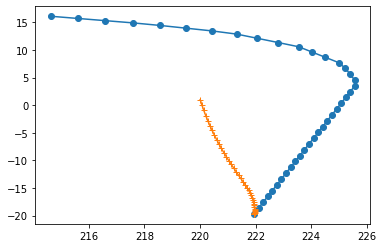

In [16]:
u_opt = sol.value(u)

z = z_0.squeeze()
zs = [z]

for i in range(N-1):
    a = model.predict([z.reshape(1, -1), u_opt[:, i].reshape(1, -1)])[0]
    z_next = np.zeros((6,))
    z_next[:3] = z[:3] + z[3:] * dt
    z_next[3:] = z[3:] + a * dt
    zs.append(z_next)
    z = z_next

zs = np.array(zs)

plt.plot(track[:, 0], track[:, 1], '-o')
plt.plot(zs[:, 0], zs[:, 1], '-+')
plt.show()

In [17]:
z_0, zs[0], track.T[:, 0], z_0[:3, 0]

(array([[221.94283081],
        [-19.6907395 ],
        [  1.41532152],
        [  0.        ],
        [  0.        ],
        [  0.        ]]),
 array([221.94283081, -19.6907395 ,   1.41532152,   0.        ,
          0.        ,   0.        ]),
 array([221.94283081, -19.6907395 ,   1.41532152]),
 array([221.94283081, -19.6907395 ,   1.41532152]))

In [18]:
track.T.shape, len(zs)

((3, 40), 40)

In [19]:
zs

array([[ 2.21942831e+02, -1.96907395e+01,  1.41532152e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.21942831e+02, -1.96907395e+01,  1.41532152e+00,
         4.46342647e-01,  1.96975851e+00,  3.72327901e-02],
       [ 2.21951758e+02, -1.96513443e+01,  1.41606618e+00,
         4.98195607e-01,  3.69174612e+00,  2.22516794e-01],
       [ 2.21961722e+02, -1.95775094e+01,  1.42051651e+00,
         4.60695352e-01,  5.55373156e+00,  2.28626575e-01],
       [ 2.21970935e+02, -1.94664348e+01,  1.42508904e+00,
         1.77793261e-01,  7.03314757e+00,  4.49267115e-01],
       [ 2.21974491e+02, -1.93257718e+01,  1.43407438e+00,
         1.63468205e-01,  8.54664099e+00,  2.54583548e-01],
       [ 2.21977761e+02, -1.91548390e+01,  1.43916606e+00,
        -2.39431954e-01,  1.00415871e+01,  4.79077797e-01],
       [ 2.21972972e+02, -1.89540073e+01,  1.44874761e+00,
        -4.06824104e-01,  1.15877248e+01,  2.61113088e-01],
       [ 2.21964836e+02, -1.87222528e+01,  1.453

In [20]:
for i in range(N):
    print(zs[i][:3], track.T[:, i])

[221.94283081 -19.6907395    1.41532152] [221.94283081 -19.6907395    1.41532152]
[221.94283081 -19.6907395    1.41532152] [222.10813233 -18.63611556   1.41532152]
[221.95175766 -19.65134433   1.41606618] [222.27343385 -17.58149162   1.41532152]
[221.96172158 -19.57750941   1.42051651] [222.43873536 -16.52686768   1.41532152]
[221.97093548 -19.46643478   1.42508904] [222.60403688 -15.47224374   1.41532152]
[221.97449135 -19.32577183   1.43407438] [222.7693384  -14.41761979   1.41532152]
[221.97776071 -19.15483901   1.43916606] [222.93463992 -13.36299585   1.41532152]
[221.97297207 -18.95400727   1.44874761] [223.09994144 -12.30837191   1.41532152]
[221.96483559 -18.72225277   1.45396987] [223.26524295 -11.25374797   1.41532152]
[221.95540213 -18.45468627   1.45961444] [223.43054447 -10.19912403   1.41532152]
[221.94320572 -18.16035588   1.46554145] [223.59584599  -9.14450009   1.41532152]
[221.93676747 -17.84618338   1.46848107] [223.76114751  -8.08987615   1.41532152]
[221.9270666  -1